# Experian workshop - Scorecard Development

In this notebook you will find an example of how to develop a scorecard using Linear Regression, how to explore and validate the results. Based on these results you can determine if the model will perform well on previously unseen data. You can alse decide at what score thresholds to Reject or Accept a customer, or Refer it for further manual assessment. 

This is only an example. You can base your work on this example, but it is not a final model appropriate for implementation. It is up to you to create a better model, that will differentiate between Good and Bad customers well enough to be implemented in a live environment. 

What constitutes a good model?
 At minimum:
 - There must be no inversions in the coefficients of the dummy variables
 - The model must validate when using the Kolmogorov–Smirnov test
 
A good model would also meet these requirements:
 - It will contain between 7 and 15 variables
 - There is a good score distribution, without large clusters of the population receiving the same or very similar score (e.g. 5% of the population all receiving 274 points)
 - The Gini coefficient of the model is as high as possible. For an application model, like the one produced here, you should aim for a Gini coefficient of at least 50-60 points. 
 
These points are explored in more detail further on in the code. However, you can and should explore other sources of information as well, including but not limitted to pandas technical documentation and statistical concepts explanations.

# Scorecard: Linear Regression

Import needed python libraries and set project path

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
#import the train_test_split functionallity from package sklearn, section model_selection. 
#This will alow us to create a random split of the sample so we can have a holdout sample to validate the model on
from sklearn.model_selection import train_test_split

In [3]:
#Import statsmodels.api needed for the model development
import statsmodels.api as sm

In [4]:
# Define the project path:
projpath = r"C:\Users\Experian workshop"

Make sure you have placed the **data_dictionary.py** and the **BankCaseStudy.csv** file in the projpath directory.
data_dictionary.py contains a mapping of the values in the data to more meaningful and easy-to-read strings. For example, in variable 'Occupation_Code', value "B" is mapped to its meaning "Self-employed".

In [5]:
# Apply data dictionary provided by client
%run "C:\Users\Experian workshop\data_dictionary.py"

## Importing data

After data supply by the client, initial data investigation comes in place and the data is prepared for modelling. This stage is called data preparation and it includes performing data quality check, data auditing, deriving variables, clarifying Good/Bad flag definition and exclusions, and choosing a sample window for modelling. The result of this data preparation is the file BankCaseStudyData.csv.

In [6]:
#Read in the data from the project directory; the data is represented as a table, here refered to as dataframe
ds = os.path.join(projpath, r"BankCaseStudyData.csv")
bcs_data = pd.read_csv(ds)

In [7]:
#Check the shape of the dateframe. The shape is shown in the format (rows, columns)
#Each row is one observation
#Each column is one variable
bcs_data.shape

(24859, 33)

Please refer to the Pandas documentation on reading data from csv and carefully parse any dates and any numeric columns which might contain decimal/thousand separators different from the default.


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [8]:
#List all variables contained in the file
bcs_data.columns

Index(['Account_Number', 'Account_Type', 'Final_Decision',
       'Current_Delinquency_status', 'Application_Date', 'Application_Score',
       'Cheque_Card_Flag', 'Existing_Customer_Flag', 'Gross_Annual_Income',
       'Home_Telephone_Number', 'Insurance_Required', 'Loan_Amount',
       'Loan_Payment_Frequency', 'Loan_Payment_Method', 'Marital_Status',
       'Number_of_Dependants', 'Number_of_Payments', 'Occupation_Code',
       'Promotion_Type', 'Residential_Status', 'Time_at_Address',
       'Time_in_Employment', 'Time_with_Bank', 'Weight_Factor', 'GB_Flag',
       'Age_of_Applicant', 'Application_Month', 'Bureau_Score',
       'SP_ER_Reference', 'SP_Number_Of_Searches_L6M', 'SP_Number_of_CCJs',
       'loan_to_income', 'split'],
      dtype='object')

In [9]:
#Check if there are observations with missing Current_Delinquency_status
bcs_data[pd.isna(bcs_data['Current_Delinquency_status'])].shape

(6044, 33)

In [10]:
#List all columns that contain the string "App" in their name
for x in bcs_data.columns:
    if "App" in x:
        print(x)

Application_Date
Application_Score
Age_of_Applicant
Application_Month


In [11]:
#Print all values of the variable Application_Month, including missing values. 
bcs_data['Application_Month'].value_counts(dropna=False)

200701    2610
200608    2485
200611    2310
200610    2176
200606    2137
200603    2121
200605    2107
200602    2070
200607    2002
200612    1692
200604    1658
200609    1491
Name: Application_Month, dtype: int64

Values are listed based on number of occurrences.

In [12]:
#List all columns that contain the string "Delinq" in their name
for x in bcs_data.columns:
    if "Delinq" in x:
        print(x)

Current_Delinquency_status


In [13]:
#Print all values of the variable Current_Delinquency_status, including missing values. 
#Print the values sorted by the value of the variable
bcs_data['Current_Delinquency_status'].value_counts(dropna=False).sort_index()

0.0    7606
1.0    9232
2.0     847
3.0      14
4.0     502
5.0     345
6.0     269
NaN    6044
Name: Current_Delinquency_status, dtype: int64

In [14]:
#check the shape of all cases with duplicated Account_Number
bcs_data[bcs_data.duplicated('Account_Number') == True].shape

(0, 33)

There are no cases with duplicated account number.

In [15]:
#Print all values of account number
bcs_data['Account_Number'].value_counts(dropna=False)

10438010993    1
10714167111    1
10348946060    1
10667991809    1
10810333669    1
10358464157    1
10944643845    1
10592193284    1
10470660870    1
10453829830    1
10492146443    1
10119398157    1
10460646156    1
10310016332    1
10924382990    1
10760626961    1
10428990565    1
10266593800    1
10912303892    1
10194545432    1
10727354720    1
10028854851    1
10955455504    1
10302455883    1
10621745914    1
10825755384    1
10928880362    1
10658128609    1
10310232800    1
10390781388    1
              ..
10764806160    1
10065261980    1
10014797215    1
10678033825    1
10949776800    1
10725094788    1
10127003011    1
10207705098    1
10340824436    1
10222923111    1
10914987015    1
10322873707    1
10248749790    1
10125491565    1
10649310235    1
10482408817    1
10849764722    1
10703797621    1
10357927287    1
10708145536    1
10643891574    1
10031807658    1
10914212041    1
10197566842    1
10498555261    1
10718562110    1
10338741631    1
10348261906   

As the account number is unique, there are 24 859 unique values. Only a limited number of rows is printed by default. This setting can be changed using the command:

pd.options.display.max_rows = N

Where N is the number of rows you want to print. This is a general settings change and it will affect the whole notebook/py script. 

In [16]:
#Print the first rows of the dataframe. 
#By default, 5 rows are printed. This can be changed by addin a number in the brackets
bcs_data.head()

,Account_Number,Account_Type,Final_Decision,Current_Delinquency_status,Application_Date,Application_Score,Cheque_Card_Flag,Existing_Customer_Flag,Gross_Annual_Income,Home_Telephone_Number,...,Weight_Factor,GB_Flag,Age_of_Applicant,Application_Month,Bureau_Score,SP_ER_Reference,SP_Number_Of_Searches_L6M,SP_Number_of_CCJs,loan_to_income,split
0,10730734532,FL,Accept,NaN,20061206,965,Y,Y,12000,N,...,2.0,NTU,28,200612,1009,2,0,0,15.50,Development
1,10803550208,VL,Decline,NaN,20060928,720,N,Y,10015,Y,...,2.0,Rejects,36,200609,784,3,0,0,29.96,Development
2,10769083290,FL,Accept,0.0,20060721,975,Y,N,11000,Y,...,2.0,Good,48,200607,940,1,2,0,45.45,Development
3,10072636331,FL,Accept,1.0,20060529,960,Y,N,16500,Y,...,2.0,Good,41,200605,902,1,1,0,31.82,Development
4,10737329597,FL,Accept,0.0,20060718,980,Y,Y,60000,Y,...,2.0,Good,37,200607,1013,1,7,0,16.67,Development


In [17]:
# Apply the data dictionary to the ds
data_dictionary(bcs_data)

#Print the first 7 rows of the dataframe. 
bcs_data.head(7)

,Account_Number,Account_Type,Final_Decision,Current_Delinquency_status,Application_Date,Application_Score,Cheque_Card_Flag,Existing_Customer_Flag,Gross_Annual_Income,Home_Telephone_Number,...,Weight_Factor,GB_Flag,Age_of_Applicant,Application_Month,Bureau_Score,SP_ER_Reference,SP_Number_Of_Searches_L6M,SP_Number_of_CCJs,loan_to_income,split
0,10730734532,Fixed Loan,Accept,NaN,20061206,965,Yes,Yes,12000,No,...,2.0,NTU,28,200612,1009,Confirmed as previous occupant,0,0,15.50,Development
1,10803550208,Variable Loan,Decline,NaN,20060928,720,No,Yes,10015,Yes,...,2.0,Rejects,36,200609,784,Not confirmed,0,0,29.96,Development
2,10769083290,Fixed Loan,Accept,0.0,20060721,975,Yes,No,11000,Yes,...,2.0,Good,48,200607,940,Confirmed,2,0,45.45,Development
3,10072636331,Fixed Loan,Accept,1.0,20060529,960,Yes,No,16500,Yes,...,2.0,Good,41,200605,902,Confirmed,1,0,31.82,Development
4,10737329597,Fixed Loan,Accept,0.0,20060718,980,Yes,Yes,60000,Yes,...,2.0,Good,37,200607,1013,Confirmed,7,0,16.67,Development
5,10464533150,Fixed Loan,Accept,1.0,20061109,920,No,No,22300,Yes,...,2.0,Good,47,200611,945,Confirmed,1,0,17.94,Development
6,10238114351,Fixed Loan,Accept,0.0,20060328,985,Yes,No,12444,Yes,...,2.0,Good,38,200603,1002,Confirmed,1,0,-9999998.00,Development


In [18]:
#Print descriptive statistics for variable Time_at_Address
bcs_data['Time_at_Address'].describe()

count    24859.000000
mean      1017.618327
std        982.916475
min          0.000000
25%        211.000000
50%        700.000000
75%       1506.000000
max       7500.000000
Name: Time_at_Address, dtype: float64

The logical expectation for a "time" variable is to be days, months or years. In this case we can see that we have an average of 1017 and values like 211, 700 and 1506 which are obviously not months or years (1506 months would mean a person living at this address for 125.5 years. We also do not expect time at address to be recorded in days.In such a case we would need further information from the data provider. 

In our case, the last two digits of the value show the number of months, and the preceeding digits show the number of months. So 1506 means 15 years 6 months. This is the same for the other time variables.

# Derive Target Variable

We create a target variable, also referred to as Good/Bad flag. This is the outcome that we are trying to predict. Our target variable is derived on the following logic:
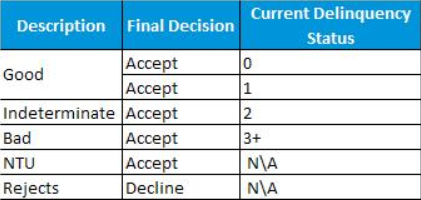

In [19]:
#Print all values sorted by index again, for easier access while defining the target variable 
bcs_data['Current_Delinquency_status'].value_counts(dropna=False).sort_index()

0.0    7606
1.0    9232
2.0     847
3.0      14
4.0     502
5.0     345
6.0     269
NaN    6044
Name: Current_Delinquency_status, dtype: int64

In [20]:
#Check the type of variable Current_Delinquency_status
bcs_data['Current_Delinquency_status'].dtype

dtype('float64')

String variables are shown as Object, or dtype('O')

NB: Pandas allows for a single variable to contain both string and numeric variables. These columns are referred to as "Mixed type columns". They are also shown as Object columns.

In [21]:
#Create a crosstable between variables Final_Decision and Current_Delinquency_status
pd.crosstab(bcs_data['Final_Decision'],bcs_data['Current_Delinquency_status'])

Current_Delinquency_status,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Final_Decision,,,,,,,
Accept,7606,9232,847,14,502,345,269


pd.crosstab prints only the non-missing values for the included variables. In order to add the missing values we can fill them with a special value for the execution of this crosstab. You can read about more options in the official documentation for Pandas crosstab.

In [22]:
#Repeat the crosstable, this time filling in the missing values and adding the total counts
pd.crosstab(bcs_data['Final_Decision'].fillna(-99),bcs_data['Current_Delinquency_status'].fillna(-99), margins="Total")

Current_Delinquency_status,-99.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,All
Final_Decision,,,,,,,,,
Accept,3447,7606,9232,847,14,502,345,269,22262
Decline,2597,0,0,0,0,0,0,0,2597
All,6044,7606,9232,847,14,502,345,269,24859


In [23]:
#Derive the target variable 

bcs_data['target'] = (
        np.select(
        condlist=[((bcs_data['Current_Delinquency_status'].isna()) & (bcs_data['Final_Decision'] == 'Accept')),
                  ((bcs_data['Current_Delinquency_status'].isna()) & (bcs_data['Final_Decision'] == 'Decline')),
                  bcs_data['Current_Delinquency_status'] < 2,
                  bcs_data['Current_Delinquency_status'] == 2,
                  bcs_data['Current_Delinquency_status']  > 2,
                  ],
        choicelist=['NTU', 'Rejects', 'Good', 'Indeterminate', 'Bad']))

Cases that meet the first condition in the condlist take the first value in the choicelist. 
So if 'Current_Delinquency_status' is missing and 'Final_Decision' is 'Accept', then this observation will receive the value "NTU" (or "Non-taken up") for the 'target' variable. "NTU"s are customers who were accepted by the bank but decided not to take the credit.

The rest of the condlist/choicelist matches follow the same logic.

In [24]:
#Print the values of the newly derived target variable
bcs_data['target'].value_counts(dropna=False)

Good             16838
NTU               3447
Rejects           2597
Bad               1130
Indeterminate      847
Name: target, dtype: int64

In [25]:
#Calculate the Bad Rate of the sample as 
# [N Bad Accounts]/([N Good Accounts]+[N Bad Accounts])
print("The Bad rate is ", round(1130/(16838+1130)*100,2), "%")

The Bad rate is  6.29 %


# Take only Good and Bad observations and continue with them

In [26]:
bcs_data = bcs_data[((bcs_data['target'] == 'Good') | (bcs_data['target'] == 'Bad'))]

In [27]:
# creating numeric binary flag for various calculations: 
#If variable 'target' = 'Good', then variable 'num_target' = 1, otherwise 'num_target'=0
bcs_data['num_target'] = np.where(bcs_data['target'] =="Good", 1, 0)

In [28]:
bcs_data.shape

(17968, 35)


# Classing / Binning

We are going to transorm the variables from vaues to ranges or lists of values. Our goal is to group customers with similar expected behaviour in one bin. When binning numeric variables, these values must be continuous. I.e. we can bin together 1 - 5, 6 - 10, but we can NOT bin together (1,3,5,7,9) and (2,4,6,8,10).

It is up to you to decide which variables to use and how to bin their values for you model. You can base that on data exploration that you carry out, on research you conduct from other sources or by any method you see fit. 

Note: Variable SP_ER_Reference shows information about UK Electoral Roll Reference. 

## Loan to income

This variable shows the loan amount as a percentage of the gross annual income. We can expect values between 0 and 100 if the loan is less than the gross annual income, and larger than 100 if the loan is more than the gross annual income. A value of -9999998 means that the loan amount value is 0 (data error); a value of -9999997 means that the gross annual income is 0 (possible data error, or the customer did not state their income, or they don't have any officially declared income). It is up to you as an analyst to decide how to treat these values.

In [29]:
#Print the values of variable loan_to_income
bcs_data['loan_to_income'].value_counts(dropna=False)

-9999997.00    910
-9999998.00    724
 20.00         293
 25.00         251
 33.33         237
 10.00         211
 50.00         196
 16.67         187
 40.00         160
 12.50         158
 30.00         129
 15.00         123
 41.67         113
 8.33           97
 26.67          93
 13.33          92
 14.29          90
 28.57          79
 5.00           77
 27.78          73
 11.11          73
 66.67          71
 22.22          66
 37.50          65
 6.67           61
 18.75          61
 12.00          59
 31.25          59
 15.38          59
 7.14           57
              ... 
 89.23           1
 539.29          1
 81.48           1
 14.09           1
 12.34           1
 18.02           1
 18.53           1
 83.70           1
 425.89          1
 50.03           1
 66.79           1
 9346.67         1
 53.55           1
 65.15           1
 25.90           1
 11.86           1
 489.67          1
 146.03          1
 13.59           1
 37.95           1
 216.36          1
 257.78     

In [30]:
#Create classing for loan_to_income by specifying the borders of the ranges
bcs_data['loan_to_income_classing'] = pd.cut(bcs_data['loan_to_income'],[-9999998.00,-9999997.00, 0, 10, 30, 60, 100,pd.np.inf],right=False)

In [31]:
#Print the values of variable loan_to_income_classing sorted by index

bcs_data['loan_to_income_classing'].value_counts(dropna=False).sort_index()

[-9999998.0, -9999997.0)     724
[-9999997.0, 0.0)            910
[0.0, 10.0)                 2420
[10.0, 30.0)                6791
[30.0, 60.0)                4429
[60.0, 100.0)               1094
[100.0, inf)                1600
Name: loan_to_income_classing, dtype: int64

In [32]:
# Visualizing the probability of being Good for each class
bcs_data.groupby(['loan_to_income_classing'])['num_target'].mean()

loan_to_income_classing
[-9999998.0, -9999997.0)    0.980663
[-9999997.0, 0.0)           0.947253
[0.0, 10.0)                 0.959091
[10.0, 30.0)                0.937712
[30.0, 60.0)                0.931587
[60.0, 100.0)               0.919561
[100.0, inf)                0.903125
Name: num_target, dtype: float64

We can see that the higher the value of the loan_to_income variable is, the lower the probability of the customer being Good. This is logical and we can confirm that the data are showing a logical relationship between the predictor and the target variable. If, for exampl, the data show that low income is related to higher probability of paying the loan, this is not logical and we shoul not use this variable in our model. We should always check that the trend in the data is logical.

## Bureau Score

Bureau score comes from the Experian bureau where data from different financtial institutions is collected and analyzed.

In [33]:
#Print the values of variable Bureau_Score
bcs_data['Bureau_Score'].value_counts(dropna=False).sort_index()

636       1
643       1
647       3
653       1
657       1
658       1
659       1
661       1
663       1
669       1
672       1
673       1
679       1
680       1
684       1
690       1
691       2
692       3
695       1
698       1
699       1
701       1
702       1
703       1
705       1
706       1
707       2
708       1
709       3
713       1
       ... 
1017     30
1019     11
1020     14
1021     15
1022      3
1023     39
1024     36
1025    180
1026      3
1027    247
1028      8
1029    188
1030      2
1031     19
1032     28
1034      2
1035      1
1036      1
1038     47
1039     52
1041     40
1042    126
1043     48
1046      1
1050      2
1052      3
1053      7
1054     37
1056     39
1058     51
Name: Bureau_Score, Length: 357, dtype: int64

In [34]:
#Create classing for Bureau_Score by specifying the borders of the ranges
bcs_data['Bureau_Score_classing'] = pd.cut(bcs_data['Bureau_Score'],[-np.inf, 764, 803, 844, 859, 877, 911, 941, 961, 971, 978, 
                                                                     990, 1012, 1025, np.inf],right=False)

In [35]:
#Print the values of variable Bureau_Score_classing sorted by index

bcs_data['Bureau_Score_classing'].value_counts(dropna=False).sort_index()

[-inf, 764.0)        258
[764.0, 803.0)       322
[803.0, 844.0)      1560
[844.0, 859.0)       857
[859.0, 877.0)       886
[877.0, 911.0)      1946
[911.0, 941.0)      2560
[941.0, 961.0)      2276
[961.0, 971.0)       924
[971.0, 978.0)      1151
[978.0, 990.0)      1041
[990.0, 1012.0)     2053
[1012.0, 1025.0)    1002
[1025.0, inf)       1132
Name: Bureau_Score_classing, dtype: int64

In [36]:
# Visualizing the probability of being Good for each class
bcs_data.groupby(['Bureau_Score_classing'])['num_target'].mean()

Bureau_Score_classing
[-inf, 764.0)       0.767442
[764.0, 803.0)      0.788820
[803.0, 844.0)      0.864103
[844.0, 859.0)      0.889148
[859.0, 877.0)      0.902935
[877.0, 911.0)      0.917780
[911.0, 941.0)      0.934375
[941.0, 961.0)      0.958260
[961.0, 971.0)      0.965368
[971.0, 978.0)      0.969592
[978.0, 990.0)      0.972142
[990.0, 1012.0)     0.974671
[1012.0, 1025.0)    0.979042
[1025.0, inf)       0.984982
Name: num_target, dtype: float64

## Residential Status

In [37]:
#Check for observations with missing Residential_Status
bcs_data[pd.isna(bcs_data['Residential_Status'])].shape

(0, 37)

In [38]:
#Print the values of variable Residential_Status
bcs_data['Residential_Status'].value_counts()

Homeowner              12202
Other                   3408
Tenant                  2254
Living with parents      104
Name: Residential_Status, dtype: int64

In [39]:
#Create classing for Residential_Status using an if/else structure
# if Residential_Status = H, then Residential_Status_classing = H, else Residential_Status_classing = 'L|O|T'

bcs_data['Residential_Status_classing'] = np.where(bcs_data['Residential_Status'] =="Homeowner", 'H', 'L|O|T')

In [40]:
bcs_data['Residential_Status_classing'].value_counts(dropna=False)

H        12202
L|O|T     5766
Name: Residential_Status_classing, dtype: int64

In [41]:
# Visualizing the probability of being Good for each class
bcs_data.groupby(['Residential_Status_classing'])['num_target'].mean()

Residential_Status_classing
H        0.952713
L|O|T    0.904093
Name: num_target, dtype: float64

In [42]:
#Check the columns contained in the dataframe. We can see the new variables we created
bcs_data.columns

Index(['Account_Number', 'Account_Type', 'Final_Decision',
       'Current_Delinquency_status', 'Application_Date', 'Application_Score',
       'Cheque_Card_Flag', 'Existing_Customer_Flag', 'Gross_Annual_Income',
       'Home_Telephone_Number', 'Insurance_Required', 'Loan_Amount',
       'Loan_Payment_Frequency', 'Loan_Payment_Method', 'Marital_Status',
       'Number_of_Dependants', 'Number_of_Payments', 'Occupation_Code',
       'Promotion_Type', 'Residential_Status', 'Time_at_Address',
       'Time_in_Employment', 'Time_with_Bank', 'Weight_Factor', 'GB_Flag',
       'Age_of_Applicant', 'Application_Month', 'Bureau_Score',
       'SP_ER_Reference', 'SP_Number_Of_Searches_L6M', 'SP_Number_of_CCJs',
       'loan_to_income', 'split', 'target', 'num_target',
       'loan_to_income_classing', 'Bureau_Score_classing',
       'Residential_Status_classing'],
      dtype='object')

# Create Dummies
In the regression model we will use variables that have values of 1 or 0. To do that, we will transform the classed variables into dummies. For example, Residential_Status_classing contains values 'H' and 'L|O|T'. It will be transformed into two new variables: Residential_Status_H and Residential_Status_L|O|T. If an observation had a value of H, it will now have Residential_Status_H = 1 and Residential_Status_L|O|T = 0

In [43]:
#Create a new frame keeping only the variables needed for the modelling process
bcs_data_mod = bcs_data[['target','num_target','loan_to_income','loan_to_income_classing','Residential_Status','Residential_Status_classing',
                         'Bureau_Score' ,'Bureau_Score_classing']].copy()

In [44]:
#Transform the variables into dummies
#by using pd.get_dummies we create a dataframe with the transformed variable
#by using pd.concat we combine these new dataframes with the initial one
#we can incorporate the pd.get_dummies step within the pd.concatenate one
bcs_data_mod = pd.concat([bcs_data_mod,
                    pd.get_dummies(bcs_data_mod['loan_to_income_classing'],prefix ='loan_to_income',dummy_na= False),
                    pd.get_dummies(bcs_data_mod['Residential_Status_classing'],prefix ='Residential_Status',dummy_na= False),
                    pd.get_dummies(bcs_data_mod['Bureau_Score_classing'],prefix ='Bureau_Score',dummy_na= False)], axis=1,ignore_index=False,join='outer')

# Model Development

In [45]:
#Check the shape of the modelling dataframe
bcs_data_mod.shape

(17968, 31)

In [46]:
#Create a holdout sample of 30% of the populaiton (test_size = 0.3)
#This will create two dataframes with variables X_train and X_test, and two with the target variable -  y_train,y_test
X_train, X_test,y_train,y_test = train_test_split(bcs_data_mod,bcs_data_mod['num_target'],test_size = 0.3,random_state=42)

In [47]:
#Create a new variable 'sample' in the two dataframes created by the train_test_split
X_train['sample'] = 'Training'
X_test['sample'] = 'Testing'

C:\ProgramData\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
#Check the shape of X_train, containing the dummy variables and the train population on which we will create the model
X_train.shape

(12577, 32)

In [49]:
#Combine the train and test dataframes back into one. 
#We will be able to identify if the observation is in train or test population by the new variable - sample
bcs_model = pd.concat([X_train,X_test],ignore_index=False,sort=False)
bcs_model = bcs_model.reset_index(drop=True)
bcs_model.shape

(17968, 32)

In [50]:
#Check the distribution of the "sample" variable. 
#The number of observations with value "Training" should match the number of rows from X_train.shape
bcs_model['sample'].value_counts(dropna=False)

Training    12577
Testing      5391
Name: sample, dtype: int64

In [51]:
bcs_model.head()

,target,num_target,loan_to_income,loan_to_income_classing,Residential_Status,Residential_Status_classing,Bureau_Score,Bureau_Score_classing,"loan_to_income_[-9999998.0, -9999997.0)","loan_to_income_[-9999997.0, 0.0)",...,"Bureau_Score_[877.0, 911.0)","Bureau_Score_[911.0, 941.0)","Bureau_Score_[941.0, 961.0)","Bureau_Score_[961.0, 971.0)","Bureau_Score_[971.0, 978.0)","Bureau_Score_[978.0, 990.0)","Bureau_Score_[990.0, 1012.0)","Bureau_Score_[1012.0, 1025.0)","Bureau_Score_[1025.0, inf)",sample
0,Good,1,34.01,"[30.0, 60.0)",Homeowner,H,1002,"[990.0, 1012.0)",0,0,...,0,0,0,0,0,0,1,0,0,Training
1,Good,1,12.50,"[10.0, 30.0)",Other,L|O|T,855,"[844.0, 859.0)",0,0,...,0,0,0,0,0,0,0,0,0,Training
2,Good,1,-9999997.00,"[-9999997.0, 0.0)",Tenant,L|O|T,970,"[961.0, 971.0)",0,1,...,0,0,0,1,0,0,0,0,0,Training
3,Good,1,18.00,"[10.0, 30.0)",Other,L|O|T,729,"[-inf, 764.0)",0,0,...,0,0,0,0,0,0,0,0,0,Training
4,Good,1,45.00,"[30.0, 60.0)",Other,L|O|T,899,"[877.0, 911.0)",0,0,...,1,0,0,0,0,0,0,0,0,Training


In [52]:
bcs_model.columns

Index(['target', 'num_target', 'loan_to_income', 'loan_to_income_classing',
       'Residential_Status', 'Residential_Status_classing', 'Bureau_Score',
       'Bureau_Score_classing', 'loan_to_income_[-9999998.0, -9999997.0)',
       'loan_to_income_[-9999997.0, 0.0)', 'loan_to_income_[0.0, 10.0)',
       'loan_to_income_[10.0, 30.0)', 'loan_to_income_[30.0, 60.0)',
       'loan_to_income_[60.0, 100.0)', 'loan_to_income_[100.0, inf)',
       'Residential_Status_H', 'Residential_Status_L|O|T',
       'Bureau_Score_[-inf, 764.0)', 'Bureau_Score_[764.0, 803.0)',
       'Bureau_Score_[803.0, 844.0)', 'Bureau_Score_[844.0, 859.0)',
       'Bureau_Score_[859.0, 877.0)', 'Bureau_Score_[877.0, 911.0)',
       'Bureau_Score_[911.0, 941.0)', 'Bureau_Score_[941.0, 961.0)',
       'Bureau_Score_[961.0, 971.0)', 'Bureau_Score_[971.0, 978.0)',
       'Bureau_Score_[978.0, 990.0)', 'Bureau_Score_[990.0, 1012.0)',
       'Bureau_Score_[1012.0, 1025.0)', 'Bureau_Score_[1025.0, inf)',
       'sample'],


In [53]:
#Define the X and y parameters needed for running the model. 
#X will contain all predictors/dummies from the Training subpopulation. y will contain the respective target variable
#In order to avoin perfect correlation, we must select a "null band" which will not be used as a predictor. 
#That is why one band is missing from each of the 3 variables
y = bcs_model[bcs_model['sample']=='Training']['num_target']
X = bcs_model[bcs_model['sample']=='Training'][['loan_to_income_[0.0, 10.0)','loan_to_income_[30.0, 60.0)',
                                                'loan_to_income_[60.0, 100.0)', 'loan_to_income_[100.0, inf)',
                                                'Residential_Status_L|O|T',
                                               'Bureau_Score_[-inf, 764.0)', 'Bureau_Score_[764.0, 803.0)',
                                               'Bureau_Score_[803.0, 844.0)', 'Bureau_Score_[844.0, 859.0)',
                                               'Bureau_Score_[859.0, 877.0)', 'Bureau_Score_[877.0, 911.0)',
                                               'Bureau_Score_[941.0, 961.0)','Bureau_Score_[961.0, 971.0)', 
                                               'Bureau_Score_[971.0, 978.0)','Bureau_Score_[978.0, 990.0)', 
                                               'Bureau_Score_[990.0, 1012.0)','Bureau_Score_[1012.0, 1025.0)', 
                                               'Bureau_Score_[1025.0, inf)']]

You can find more information about the Generalized Linear Models here:
https://www.statsmodels.org/stable/glm.html

In [54]:
#Define the model parameters and fit it to the data, print a summary of the model
X = sm.tools.tools.add_constant(X)
model_1 = sm.GLM(y,X,family=sm.genmod.families.Binomial(link=sm.genmod.families.links.logit))
model_final = model_1.fit()
print(model_final.summary())

C:\ProgramData\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_target   No. Observations:                12577
Model:                            GLM   Df Residuals:                    12558
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2774.5
Date:                Mon, 31 May 2021   Deviance:                       5549.0
Time:                        20:50:40   Pearson chi2:                 1.26e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In order to know that all bands are statistically significant, the P>|z| value must be less than 0.05 

Moreover, the points assigned to each band should follow a linear trend. For example, the higher the Bureau score is, the higher the points they should receive. However, we can see that in customers with Bureau score between 978 and 990 are assigned less points (have a lower coefficient) than Bureau score 971 to 978. This inversion is incorrect and should be fixed in order to produce a proper model. There are several ways to correct an inversion:
- merge bands together
- distribute the band with the inversion into the neighbouring bands; e.g. create two new bands: [971 : 985),[985 : 1012)
- remove the variable if the inversion cannot be corrected

In [55]:
#the model is saved as python object
model_final

In [56]:
#Create a new variable with the prediction from the model 
X['Prediction'] = model_final.predict()

In [57]:
#by printing the X dataframe we can see the new column
X

,const,"loan_to_income_[0.0, 10.0)","loan_to_income_[30.0, 60.0)","loan_to_income_[60.0, 100.0)","loan_to_income_[100.0, inf)",Residential_Status_L|O|T,"Bureau_Score_[-inf, 764.0)","Bureau_Score_[764.0, 803.0)","Bureau_Score_[803.0, 844.0)","Bureau_Score_[844.0, 859.0)","Bureau_Score_[859.0, 877.0)","Bureau_Score_[877.0, 911.0)","Bureau_Score_[941.0, 961.0)","Bureau_Score_[961.0, 971.0)","Bureau_Score_[971.0, 978.0)","Bureau_Score_[978.0, 990.0)","Bureau_Score_[990.0, 1012.0)","Bureau_Score_[1012.0, 1025.0)","Bureau_Score_[1025.0, inf)",Prediction
0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.970305
1,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.883916
2,1.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.966271
3,1.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.759434
4,1.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.901531
5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.974501
6,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.960500
7,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.981944
8,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.965495
9,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.960506


In [58]:
y.mean()

0.9349606424425538

In [59]:
#Save as pickle file
bcs_model.to_pickle(projpath + r"\loan_model.pkl")

In [60]:
bcs_model.columns

Index(['target', 'num_target', 'loan_to_income', 'loan_to_income_classing',
       'Residential_Status', 'Residential_Status_classing', 'Bureau_Score',
       'Bureau_Score_classing', 'loan_to_income_[-9999998.0, -9999997.0)',
       'loan_to_income_[-9999997.0, 0.0)', 'loan_to_income_[0.0, 10.0)',
       'loan_to_income_[10.0, 30.0)', 'loan_to_income_[30.0, 60.0)',
       'loan_to_income_[60.0, 100.0)', 'loan_to_income_[100.0, inf)',
       'Residential_Status_H', 'Residential_Status_L|O|T',
       'Bureau_Score_[-inf, 764.0)', 'Bureau_Score_[764.0, 803.0)',
       'Bureau_Score_[803.0, 844.0)', 'Bureau_Score_[844.0, 859.0)',
       'Bureau_Score_[859.0, 877.0)', 'Bureau_Score_[877.0, 911.0)',
       'Bureau_Score_[911.0, 941.0)', 'Bureau_Score_[941.0, 961.0)',
       'Bureau_Score_[961.0, 971.0)', 'Bureau_Score_[971.0, 978.0)',
       'Bureau_Score_[978.0, 990.0)', 'Bureau_Score_[990.0, 1012.0)',
       'Bureau_Score_[1012.0, 1025.0)', 'Bureau_Score_[1025.0, inf)',
       'sample'],


In [61]:
bcs_model.head()

,target,num_target,loan_to_income,loan_to_income_classing,Residential_Status,Residential_Status_classing,Bureau_Score,Bureau_Score_classing,"loan_to_income_[-9999998.0, -9999997.0)","loan_to_income_[-9999997.0, 0.0)",...,"Bureau_Score_[877.0, 911.0)","Bureau_Score_[911.0, 941.0)","Bureau_Score_[941.0, 961.0)","Bureau_Score_[961.0, 971.0)","Bureau_Score_[971.0, 978.0)","Bureau_Score_[978.0, 990.0)","Bureau_Score_[990.0, 1012.0)","Bureau_Score_[1012.0, 1025.0)","Bureau_Score_[1025.0, inf)",sample
0,Good,1,34.01,"[30.0, 60.0)",Homeowner,H,1002,"[990.0, 1012.0)",0,0,...,0,0,0,0,0,0,1,0,0,Training
1,Good,1,12.50,"[10.0, 30.0)",Other,L|O|T,855,"[844.0, 859.0)",0,0,...,0,0,0,0,0,0,0,0,0,Training
2,Good,1,-9999997.00,"[-9999997.0, 0.0)",Tenant,L|O|T,970,"[961.0, 971.0)",0,1,...,0,0,0,1,0,0,0,0,0,Training
3,Good,1,18.00,"[10.0, 30.0)",Other,L|O|T,729,"[-inf, 764.0)",0,0,...,0,0,0,0,0,0,0,0,0,Training
4,Good,1,45.00,"[30.0, 60.0)",Other,L|O|T,899,"[877.0, 911.0)",0,0,...,1,0,0,0,0,0,0,0,0,Training


In [62]:
X.columns.values

array(['const', 'loan_to_income_[0.0, 10.0)',
       'loan_to_income_[30.0, 60.0)', 'loan_to_income_[60.0, 100.0)',
       'loan_to_income_[100.0, inf)', 'Residential_Status_L|O|T',
       'Bureau_Score_[-inf, 764.0)', 'Bureau_Score_[764.0, 803.0)',
       'Bureau_Score_[803.0, 844.0)', 'Bureau_Score_[844.0, 859.0)',
       'Bureau_Score_[859.0, 877.0)', 'Bureau_Score_[877.0, 911.0)',
       'Bureau_Score_[941.0, 961.0)', 'Bureau_Score_[961.0, 971.0)',
       'Bureau_Score_[971.0, 978.0)', 'Bureau_Score_[978.0, 990.0)',
       'Bureau_Score_[990.0, 1012.0)', 'Bureau_Score_[1012.0, 1025.0)',
       'Bureau_Score_[1025.0, inf)', 'Prediction'], dtype=object)

In [63]:
#create a new dictionary containing the dummy and its coefficient from the model
model_coefs = {"loan_to_income_[0.0, 10.0)" :        0.5665,     
        "loan_to_income_[30.0, 60.0)" :     -0.1566 ,     
        "loan_to_income_[60.0, 100.0)" :      -0.1924,   
        "loan_to_income_[100.0, inf)" :      -0.2832,
        "Residential_Status_L|O|T" :         -0.1193,
        "Bureau_Score_[-inf, 764.0)" :      -1.4556,
        "Bureau_Score_[764.0, 803.0)" :     -1.5022,
        "Bureau_Score_[803.0, 844.0)" :      -0.8944,
        "Bureau_Score_[844.0, 859.0)" :       -0.5752,
        "Bureau_Score_[859.0, 877.0)" :       -0.5074,
        "Bureau_Score_[877.0, 911.0)" :       -0.2342,
        "Bureau_Score_[941.0, 961.0)" :        0.4668,
        "Bureau_Score_[961.0, 971.0)" :        0.7499,
        "Bureau_Score_[971.0, 978.0)" :        0.9180,
        "Bureau_Score_[978.0, 990.0)" :        0.8559,
        "Bureau_Score_[990.0, 1012.0)" :       0.9188,
        "Bureau_Score_[1012.0, 1025.0)" :      1.0444,
        "Bureau_Score_[1025.0, inf)" :         1.4282}

In [64]:
#Define a function that takes the dataframe, value of the intercept from the model and 
#     the dictionary of dummy - coefficient and creates a new variable - score

def score(df, intercept, coefs):
    value_to_add = 0
   
    for name, coef in coefs.items():
        value_to_add += coef*(df[name])
       
    df["Score"] = round((intercept + value_to_add)*100,0)

In [65]:
#Execute the fucnction on the full dataframe containing both Training and Testing populations
score(bcs_model, 2.7245, model_coefs)

# Building SDR

The SDR, or Score Distribution Report, shows us how the score is distributed throughout the population. We want to have a good spread without clusters in a specific score. Having clusters would mean that the scorecard does not recognize the differences between customers well enough.

In [66]:
#Print several values of the score
bcs_model['Score']

0        349.0
1        203.0
2        336.0
3        115.0
4        221.0
5        364.0
6        319.0
7        400.0
8        333.0
9        319.0
10       241.0
11       346.0
12       434.0
13       364.0
14       232.0
15       245.0
16       249.0
17       415.0
18       377.0
19       218.0
20       209.0
21       415.0
22       272.0
23       261.0
24       307.0
25       421.0
26       422.0
27       110.0
28       203.0
29       210.0
         ...  
17938     82.0
17939    415.0
17940    421.0
17941    342.0
17942    272.0
17943    294.0
17944    272.0
17945    336.0
17946    155.0
17947    347.0
17948    364.0
17949    364.0
17950    349.0
17951    203.0
17952    364.0
17953    349.0
17954    215.0
17955    307.0
17956    261.0
17957    361.0
17958    400.0
17959    349.0
17960    409.0
17961    221.0
17962    261.0
17963    272.0
17964    237.0
17965    317.0
17966    339.0
17967    421.0
Name: Score, Length: 17968, dtype: float64

In [67]:
#Split the dataframe into Training (aka Development) and Testing(aka Validation)
bcs_dev = bcs_model[bcs_model['sample'] == 'Training']
bcs_val = bcs_model[bcs_model['sample'] == 'Testing']

In [68]:
#We want to see the score distribution at every 5% of the score. To do that,first we check the value at each 5th percentile
for i in range(0,101,5):
    print(np.percentile(bcs_dev['Score'],i), ",")

82.0 ,
155.0 ,
183.0 ,
206.0 ,
221.0 ,
233.0 ,
249.0 ,
257.0 ,
272.0 ,
292.0 ,
307.0 ,
319.0 ,
333.0 ,
347.0 ,
349.0 ,
361.0 ,
364.0 ,
364.0 ,
400.0 ,
415.0 ,
472.0 ,


In [69]:
#We can also check the max value of the score
max(bcs_dev['Score'])

472.0

In [70]:
bcs_dev['Score'].describe()

count    12577.000000
mean       295.284010
std         80.993866
min         82.000000
25%        233.000000
50%        307.000000
75%        361.000000
max        472.000000
Name: Score, dtype: float64

In [71]:
#We create a crosstable of the score binned at 5% and the target variable 
pd.crosstab(pd.cut(bcs_dev['Score'],bins=[82 ,
                                            155 ,
                                            183 ,
                                            206 ,
                                            221 ,
                                            233 ,
                                            249 ,
                                            257 ,
                                            272 ,
                                            292 ,
                                            307 ,
                                            319 ,
                                            333 ,
                                            347 ,
                                            349 ,
                                            361 ,
                                            364 ,
                                            400 ,
                                            415 ,
                                            472]), bcs_dev["target"])

target,Bad,Good
Score,,
"(82, 155]",146,534
"(155, 183]",102,572
"(183, 206]",66,483
"(206, 221]",69,539
"(221, 233]",67,561
"(233, 249]",77,869
"(249, 257]",19,287
"(257, 272]",59,860
"(272, 292]",21,364


In [72]:
#Run the table again, saving it as an object
sdr = pd.crosstab(pd.cut(bcs_dev['Score'],bins=[82 ,
                                                155 ,
                                                183 ,
                                                206 ,
                                                221 ,
                                                233 ,
                                                249 ,
                                                257 ,
                                                272 ,
                                                292 ,
                                                307 ,
                                                319 ,
                                                333 ,
                                                347 ,
                                                349 ,
                                                361 ,
                                                364 ,
                                                400 ,
                                                415 ,
                                                472]), bcs_dev["target"])

In [73]:
#Calculate the Bad rate at each row, present it as a percent in format NN.NN%
sdr['Bad Rate'] = round((sdr["Bad"]/(sdr["Bad"] + sdr["Good"]))*100,2)

In [74]:
#Calculate the Good to Bad rate at each row, showing how many Good accounts we have for 1 Bad account
sdr['GB Odds'] = round(sdr["Good"]/sdr["Bad"],2)

In [75]:
#Calculate the percent of the total population at each row
sdr['% Total'] = round((sdr["Bad"] + sdr["Good"])/(sdr["Bad"].sum() + sdr["Good"].sum())*100,2)

In [76]:
sdr

target,Bad,Good,Bad Rate,GB Odds,% Total
Score,,,,,
"(82, 155]",146,534,21.47,3.66,5.41
"(155, 183]",102,572,15.13,5.61,5.36
"(183, 206]",66,483,12.02,7.32,4.37
"(206, 221]",69,539,11.35,7.81,4.84
"(221, 233]",67,561,10.67,8.37,5.00
"(233, 249]",77,869,8.14,11.29,7.53
"(249, 257]",19,287,6.21,15.11,2.44
"(257, 272]",59,860,6.42,14.58,7.31
"(272, 292]",21,364,5.45,17.33,3.06


Based on the score distribution report and the Bad rate of each band, you can decide the thresholds for Rejecting,Referring or Accepting a customer.

For example:
- Reject - All customers with score less than 200 points
- Refer for further manual assessment - All customers with score greater or equal to 200 points, and less than 250 points
- Accept - All customers with score greater or equal to 250 points. 

The decision and thresholds depend entirely on what strategy you as the bank want to adopt. This is only an example and you should determine these thresholds for your particular model and considerations.

# Validation

In order to know that the model will perform equally well on new data that the bank will use it on, we must perform a validation test. To see if the model performs as well on data different from the one it was developped on, we will use the Kolmogorov–Smirnov test on two samples. Previously we split the data into Development and Validation. We used the Development sample to create the model. We then scored the full dataframe and split it again into Development and Validation. Now we will perform the KS validation test which compares the distribution of the cumulative number of Goods, Bads and Total in the samples. In order to confirm that the model works well, we must confirm that the distributions are not statistically different when comparing the three populations - Development, Validation and the Full sample. This results in 9 comparisons of maximum difference of cumulative numbers:

Development and Validation popultions - Bad accounts

Development and Full populations - Bad accounts

Validation and Full populations - Bad accounts
    
    
Development and Validation popultions - Good Accounts

Development and Full populations - Good Accounts

Validation and Full populations - Good Accounts
    
    
Development and Validation popultions - Total accounts

Development and Full populations - Total accounts

Validation and Full populations - Total accounts

In [77]:
#Print the number of accounts in Training and Testing again 
bcs_model['sample'].value_counts(dropna=False)

Training    12577
Testing      5391
Name: sample, dtype: int64

We already created a 5% SDR on the Development population. Now we apply these bands to the Development, Validation and Full populations and save them as new dataframes. The 5% bands are created based on the Development population and then used on the other two populations without changing them.

In [78]:
validation_dev = pd.crosstab(pd.cut(bcs_dev['Score'],bins=[82 ,
                                                                155 ,
                                                                183 ,
                                                                206 ,
                                                                221 ,
                                                                233 ,
                                                                249 ,
                                                                257 ,
                                                                272 ,
                                                                292 ,
                                                                307 ,
                                                                319 ,
                                                                333 ,
                                                                347 ,
                                                                349 ,
                                                                361 ,
                                                                364 ,
                                                                400 ,
                                                                415 ,
                                                                472]), bcs_dev["target"])

In [79]:
validation_val = pd.crosstab(pd.cut(bcs_val['Score'],bins=[82 ,
                                                            155 ,
                                                            183 ,
                                                            206 ,
                                                            221 ,
                                                            233 ,
                                                            249 ,
                                                            257 ,
                                                            272 ,
                                                            292 ,
                                                            307 ,
                                                            319 ,
                                                            333 ,
                                                            347 ,
                                                            349 ,
                                                            361 ,
                                                            364 ,
                                                            400 ,
                                                            415 ,
                                                            472]), bcs_val["target"])

In [80]:
validation_total = pd.crosstab(pd.cut(bcs_model['Score'],bins=[82 ,
                                                                155 ,
                                                                183 ,
                                                                206 ,
                                                                221 ,
                                                                233 ,
                                                                249 ,
                                                                257 ,
                                                                272 ,
                                                                292 ,
                                                                307 ,
                                                                319 ,
                                                                333 ,
                                                                347 ,
                                                                349 ,
                                                                361 ,
                                                                364 ,
                                                                400 ,
                                                                415 ,
                                                                472]), bcs_model["target"])

In [81]:
validation_total.reset_index(inplace = True)
validation_total.columns.name = 'index'
validation_dev.reset_index(inplace = True)
validation_dev.columns.name = 'index'
validation_val.reset_index(inplace = True)
validation_val.columns.name = 'index'

In [82]:
validation_total['total'] = validation_total["Bad"] + validation_total["Good"]
validation_dev['total'] = validation_dev["Bad"] + validation_dev["Good"]
validation_val['total'] = validation_val["Bad"]  + validation_val["Good"]

In [83]:
validation_total

index,Score,Bad,Good,total
0,"(82, 155]",196,789,985
1,"(155, 183]",130,865,995
2,"(183, 206]",96,697,793
3,"(206, 221]",92,776,868
4,"(221, 233]",86,819,905
5,"(233, 249]",110,1262,1372
6,"(249, 257]",28,431,459
7,"(257, 272]",84,1251,1335
8,"(272, 292]",28,520,548
9,"(292, 307]",42,999,1041


In [84]:
df_combined = validation_dev.merge(right=validation_val, on='Score').merge(right=validation_total, on='Score')
df_combined

index,Score,Bad_x,Good_x,total_x,Bad_y,Good_y,total_y,Bad,Good,total
0,"(82, 155]",146,534,680,50,255,305,196,789,985
1,"(155, 183]",102,572,674,28,293,321,130,865,995
2,"(183, 206]",66,483,549,30,214,244,96,697,793
3,"(206, 221]",69,539,608,23,237,260,92,776,868
4,"(221, 233]",67,561,628,19,258,277,86,819,905
5,"(233, 249]",77,869,946,33,393,426,110,1262,1372
6,"(249, 257]",19,287,306,9,144,153,28,431,459
7,"(257, 272]",59,860,919,25,391,416,84,1251,1335
8,"(272, 292]",21,364,385,7,156,163,28,520,548
9,"(292, 307]",27,697,724,15,302,317,42,999,1041


In [85]:
df_combined.columns

Index(['Score', 'Bad_x', 'Good_x', 'total_x', 'Bad_y', 'Good_y', 'total_y',
       'Bad', 'Good', 'total'],
      dtype='object', name='index')

In [86]:
renaming = {'Bad_x': 'bad_dev', 
            'Bad_y': 'bad_val', 
            'Good_x': 'good_dev', 
            'Good_y': 'good_val', 
            'Bad': 'bad_all', 
            'Good': 'good_all',
            'total_x': 'total_dev',
            'total_y': 'total_val',
            'total': 'total_all'}

In [87]:
df_combined = df_combined.rename(columns = renaming)
df_combined

index,Score,bad_dev,good_dev,total_dev,bad_val,good_val,total_val,bad_all,good_all,total_all
0,"(82, 155]",146,534,680,50,255,305,196,789,985
1,"(155, 183]",102,572,674,28,293,321,130,865,995
2,"(183, 206]",66,483,549,30,214,244,96,697,793
3,"(206, 221]",69,539,608,23,237,260,92,776,868
4,"(221, 233]",67,561,628,19,258,277,86,819,905
5,"(233, 249]",77,869,946,33,393,426,110,1262,1372
6,"(249, 257]",19,287,306,9,144,153,28,431,459
7,"(257, 272]",59,860,919,25,391,416,84,1251,1335
8,"(272, 292]",21,364,385,7,156,163,28,520,548
9,"(292, 307]",27,697,724,15,302,317,42,999,1041


In [88]:
#Set the Score variable as an indef for the dataframe
df_combined.set_index('Score',inplace=True)

All of the following steps can also be conducted in excel. Please refer to the excel file "Excel validation test.xlsx"

In [89]:
#Export the above table in order to continue work in excel (if you choose to conduct this test in Excel)
df_combined.to_csv(os.path.join(projpath,"Combined_frequencies_per_subpopulation.csv"))

In [90]:
#Transform the number of accounts per row into cummulative number of accounts
df_combined = df_combined.cumsum()

In [91]:
renaming_2 = {'bad_dev': 'cum_bad_dev', 
              'good_dev': 'cum_good_dev', 
              'total_dev': 'cum_total_dev', 
              'bad_val': 'cum_bad_val', 
              'good_val': 'cum_good_val', 
              'total_val': 'cum_total_val',
              'bad_all': 'cum_bad_all',
              'good_all': 'cum_good_all',
              'total_all': 'cum_total_all'}

In [92]:
df_combined = df_combined.rename(columns = renaming_2)
df_combined

index,cum_bad_dev,cum_good_dev,cum_total_dev,cum_bad_val,cum_good_val,cum_total_val,cum_bad_all,cum_good_all,cum_total_all
Score,,,,,,,,,
"(82, 155]",146,534,680,50,255,305,196,789,985
"(155, 183]",248,1106,1354,78,548,626,326,1654,1980
"(183, 206]",314,1589,1903,108,762,870,422,2351,2773
"(206, 221]",383,2128,2511,131,999,1130,514,3127,3641
"(221, 233]",450,2689,3139,150,1257,1407,600,3946,4546
"(233, 249]",527,3558,4085,183,1650,1833,710,5208,5918
"(249, 257]",546,3845,4391,192,1794,1986,738,5639,6377
"(257, 272]",605,4705,5310,217,2185,2402,822,6890,7712
"(272, 292]",626,5069,5695,224,2341,2565,850,7410,8260


In [93]:
#Calculate the cumulative percent for good,bad,total for the 3 populations
df_combined['cum_%_bad_dev'] = round(df_combined['cum_bad_dev']/df_combined.iloc[-1,0]*100,2)
df_combined['cum_%_bad_val'] = round(df_combined['cum_bad_val']/df_combined.iloc[-1,3]*100,2)
df_combined['cum_%_bad_all'] = round(df_combined['cum_bad_all']/df_combined.iloc[-1,6]*100,2)

df_combined['cum_%_good_dev'] = round(df_combined['cum_good_dev']/df_combined.iloc[-1,1]*100,2)
df_combined['cum_%_good_val'] = round(df_combined['cum_good_val']/df_combined.iloc[-1,4]*100,2)
df_combined['cum_%_good_all'] = round(df_combined['cum_good_all']/df_combined.iloc[-1,7]*100,2)

df_combined['cum_%_total_dev'] = round(df_combined['cum_total_dev']/df_combined.iloc[-1,2]*100,2)
df_combined['cum_%_total_val'] = round(df_combined['cum_total_val']/df_combined.iloc[-1,5]*100,2)
df_combined['cum_%_total_all'] = round(df_combined['cum_total_all']/df_combined.iloc[-1,8]*100,2)

In [94]:
df_combined

index,cum_bad_dev,cum_good_dev,cum_total_dev,cum_bad_val,cum_good_val,cum_total_val,cum_bad_all,cum_good_all,cum_total_all,cum_%_bad_dev,cum_%_bad_val,cum_%_bad_all,cum_%_good_dev,cum_%_good_val,cum_%_good_all,cum_%_total_dev,cum_%_total_val,cum_%_total_all
Score,,,,,,,,,,,,,,,,,,
"(82, 155]",146,534,680,50,255,305,196,789,985,17.89,16.03,17.38,4.55,5.02,4.69,5.41,5.66,5.49
"(155, 183]",248,1106,1354,78,548,626,326,1654,1980,30.39,25.00,28.90,9.41,10.80,9.83,10.78,11.62,11.03
"(183, 206]",314,1589,1903,108,762,870,422,2351,2773,38.48,34.62,37.41,13.52,15.01,13.97,15.15,16.15,15.45
"(206, 221]",383,2128,2511,131,999,1130,514,3127,3641,46.94,41.99,45.57,18.11,19.68,18.59,19.98,20.98,20.28
"(221, 233]",450,2689,3139,150,1257,1407,600,3946,4546,55.15,48.08,53.19,22.89,24.77,23.45,24.98,26.12,25.32
"(233, 249]",527,3558,4085,183,1650,1833,710,5208,5918,64.58,58.65,62.94,30.28,32.51,30.96,32.51,34.03,32.97
"(249, 257]",546,3845,4391,192,1794,1986,738,5639,6377,66.91,61.54,65.43,32.73,35.35,33.52,34.95,36.87,35.52
"(257, 272]",605,4705,5310,217,2185,2402,822,6890,7712,74.14,69.55,72.87,40.05,43.05,40.95,42.26,44.59,42.96
"(272, 292]",626,5069,5695,224,2341,2565,850,7410,8260,76.72,71.79,75.35,43.14,46.13,44.04,45.32,47.61,46.01


In [95]:
#Calculate the differences between the cumulative values for each row
df_combined['dev_val_cum_%diff_bad'] = abs(df_combined['cum_%_bad_dev'] - df_combined['cum_%_bad_val'])
df_combined['dev_all_cum_%diff_bad'] = abs(df_combined['cum_%_bad_dev'] - df_combined['cum_%_bad_all'])
df_combined['val_all_cum_%diff_bad'] = abs(df_combined['cum_%_bad_val'] - df_combined['cum_%_bad_all'])

df_combined['dev_val_cum_%diff_good'] = abs(df_combined['cum_%_good_dev'] - df_combined['cum_%_good_val'])
df_combined['dev_all_cum_%diff_good'] = abs(df_combined['cum_%_good_dev'] - df_combined['cum_%_good_all'])                                             
df_combined['val_all_cum_%diff_good'] = abs(df_combined['cum_%_good_val'] - df_combined['cum_%_good_all'])

df_combined['dev_val_cum_%diff_total'] = abs(df_combined['cum_%_total_dev'] - df_combined['cum_%_total_val'])
df_combined['dev_all_cum_%diff_total'] = abs(df_combined['cum_%_total_dev'] - df_combined['cum_%_total_all'])
df_combined['val_all_cum_%diff_total'] = abs(df_combined['cum_%_total_val'] - df_combined['cum_%_total_all'])

In [96]:
df_combined

index,cum_bad_dev,cum_good_dev,cum_total_dev,cum_bad_val,cum_good_val,cum_total_val,cum_bad_all,cum_good_all,cum_total_all,cum_%_bad_dev,...,cum_%_total_all,dev_val_cum_%diff_bad,dev_all_cum_%diff_bad,val_all_cum_%diff_bad,dev_val_cum_%diff_good,dev_all_cum_%diff_good,val_all_cum_%diff_good,dev_val_cum_%diff_total,dev_all_cum_%diff_total,val_all_cum_%diff_total
Score,,,,,,,,,,,,,,,,,,,,,
"(82, 155]",146,534,680,50,255,305,196,789,985,17.89,...,5.49,1.86,0.51,1.35,0.47,0.14,0.33,0.25,0.08,0.17
"(155, 183]",248,1106,1354,78,548,626,326,1654,1980,30.39,...,11.03,5.39,1.49,3.90,1.39,0.42,0.97,0.84,0.25,0.59
"(183, 206]",314,1589,1903,108,762,870,422,2351,2773,38.48,...,15.45,3.86,1.07,2.79,1.49,0.45,1.04,1.00,0.30,0.70
"(206, 221]",383,2128,2511,131,999,1130,514,3127,3641,46.94,...,20.28,4.95,1.37,3.58,1.57,0.48,1.09,1.00,0.30,0.70
"(221, 233]",450,2689,3139,150,1257,1407,600,3946,4546,55.15,...,25.32,7.07,1.96,5.11,1.88,0.56,1.32,1.14,0.34,0.80
"(233, 249]",527,3558,4085,183,1650,1833,710,5208,5918,64.58,...,32.97,5.93,1.64,4.29,2.23,0.68,1.55,1.52,0.46,1.06
"(249, 257]",546,3845,4391,192,1794,1986,738,5639,6377,66.91,...,35.52,5.37,1.48,3.89,2.62,0.79,1.83,1.92,0.57,1.35
"(257, 272]",605,4705,5310,217,2185,2402,822,6890,7712,74.14,...,42.96,4.59,1.27,3.32,3.00,0.90,2.10,2.33,0.70,1.63
"(272, 292]",626,5069,5695,224,2341,2565,850,7410,8260,76.72,...,46.01,4.93,1.37,3.56,2.99,0.90,2.09,2.29,0.69,1.60


You can read more about the KS test here:
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test .
Take note of the formula for a two-sample KS test and the value of c(alpha) at 5% confidence interval.

In [97]:
#Calculate the critical KS value for each set of population and good/bad/total.
#We will perform the test at 5% confidence interval
KS_dev_val_bad = round(1.358*np.sqrt((df_combined.iloc[-1,0] + df_combined.iloc[-1,3])/(df_combined.iloc[-1,0]*df_combined.iloc[-1,3]))*100,2)
KS_dev_all_bad = round(1.358*np.sqrt((df_combined.iloc[-1,0] + df_combined.iloc[-1,6])/(df_combined.iloc[-1,0]*df_combined.iloc[-1,6]))*100,2)
KS_val_all_bad = round(1.358*np.sqrt((df_combined.iloc[-1,3] + df_combined.iloc[-1,6])/(df_combined.iloc[-1,3]*df_combined.iloc[-1,6]))*100,2)

KS_dev_val_good = round(1.358*np.sqrt((df_combined.iloc[-1,1] + df_combined.iloc[-1,4])/(df_combined.iloc[-1,1]*df_combined.iloc[-1,4]))*100,2)
KS_dev_all_good = round(1.358*np.sqrt((df_combined.iloc[-1,1] + df_combined.iloc[-1,7])/(df_combined.iloc[-1,1]*df_combined.iloc[-1,7]))*100,2)
KS_val_all_good = round(1.358*np.sqrt((df_combined.iloc[-1,4] + df_combined.iloc[-1,7])/(df_combined.iloc[-1,4]*df_combined.iloc[-1,7]))*100,2)

KS_dev_val_total = round(1.358*np.sqrt((df_combined.iloc[-1,2] + df_combined.iloc[-1,5])/(df_combined.iloc[-1,2]*df_combined.iloc[-1,5]))*100,2)
KS_dev_all_total = round(1.358*np.sqrt((df_combined.iloc[-1,2] + df_combined.iloc[-1,8])/(df_combined.iloc[-1,2]*df_combined.iloc[-1,8]))*100,2)
KS_val_all_total = round(1.358*np.sqrt((df_combined.iloc[-1,5] + df_combined.iloc[-1,8])/(df_combined.iloc[-1,5]*df_combined.iloc[-1,8]))*100,2)

In [98]:
#Define the sets of values that are going to be compared. 
#E.g. The maximum difference between bad accounts in the Development and Validation samples will be compared 
#     to the critical value calculated in KS_dev_val_bad 
test = {'dev_val_cum_%diff_bad': KS_dev_val_bad,
        'dev_all_cum_%diff_bad': KS_dev_all_bad,
        'val_all_cum_%diff_bad': KS_val_all_bad, 
        
        'dev_val_cum_%diff_good':KS_dev_val_good, 
        'dev_all_cum_%diff_good': KS_dev_all_good, 
        'val_all_cum_%diff_good': KS_val_all_good,
        
        'dev_val_cum_%diff_total': KS_dev_val_total, 
        'dev_all_cum_%diff_total':KS_dev_all_total, 
        'val_all_cum_%diff_total':KS_val_all_total}

In [99]:
#Carry out the comparison by taking the maximum difference and comparing it to the critical value
#If the maximum difference is lower than the critical value, that means that the distributions are not statistically different
#    and the model validates successfully
#All 9 points of comparison must validate in order to confirm that the model is valid as a whole

validation = {}
for key, value in test.items():
    if df_combined[key].max() < value:
        validation[key] = 'Valid'
    else:
        validation[key] = 'Invalid'  

In [100]:
for key, value in validation.items():
    print(f'{key} is {value}!')

dev_val_cum_%diff_bad is Valid!
dev_all_cum_%diff_bad is Valid!
val_all_cum_%diff_bad is Valid!
dev_val_cum_%diff_good is Invalid!
dev_all_cum_%diff_good is Valid!
val_all_cum_%diff_good is Valid!
dev_val_cum_%diff_total is Invalid!
dev_all_cum_%diff_total is Valid!
val_all_cum_%diff_total is Valid!


There are two tests that fail which means that the difference in the distributions is statistically significant and the model will not perform as well on new data as it does on the development population. 
If a model is not valid / is not expected to perform well on new data, we can:

- Change the classing in one or more variables
- Remove one or more variables from the model
- Add one or more new variables to the model

In addition to the example tests performed here, you are also encouraged to learn more about and calculate the Gini coefficient which will show how well the model predicts the outcome.